In [113]:
pip install neurokit2

In [114]:
pip install cvxopt==1.2.6

In [115]:
pip install biosppy==0.6.1

In [116]:
pip install mne

In [117]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/Food_VR/GSR_Preprocessing/W&S_D_Shimmer_GSR')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import re
import csv
import scipy.io
import biosppy
import mne
import neurokit2 as nk
import cvxopt as cv
import cvxopt.solvers
import ast
import os
import scipy.io
from sklearn.preprocessing import LabelEncoder
import time
import datetime
from datetime import datetime
import glob
from scipy.stats import zscore, norm
from neurokit2 import eda_phasic
from scipy.stats import linregress
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from plotly import graph_objects as go

In [119]:
with open('/content/gdrive/My Drive/Food_VR/Food_VR/GSR_Processing/GSR_Data/Subj_VR_820_Session1_Shimmer_89C4_Calibrated_SD.csv', 'r') as file:
  reader = csv.reader(file)
  lists = []
  for row in reader:
    lists.append(row)

In [120]:
del lists[0]

In [121]:
lists[0][0]

'Shimmer_89C4_Timestamp_Unix_CAL\tShimmer_89C4_Accel_LN_X_CAL\tShimmer_89C4_Accel_LN_Y_CAL\tShimmer_89C4_Accel_LN_Z_CAL\tShimmer_89C4_Accel_WR_X_CAL\tShimmer_89C4_Accel_WR_Y_CAL\tShimmer_89C4_Accel_WR_Z_CAL\tShimmer_89C4_GSR_Range_CAL\tShimmer_89C4_GSR_Skin_Conductance_CAL\tShimmer_89C4_GSR_Skin_Resistance_CAL\tShimmer_89C4_Gyro_X_CAL\tShimmer_89C4_Gyro_Y_CAL\tShimmer_89C4_Gyro_Z_CAL\tShimmer_89C4_Mag_X_CAL\tShimmer_89C4_Mag_Y_CAL\tShimmer_89C4_Mag_Z_CAL\t'

In [122]:
newlists = []
for i in lists:
  for j in i:
    newlists.append(list(j.split('\t')))

In [123]:
Dataframe = pd.DataFrame(newlists, columns = newlists[0])

In [124]:
Dataframe = Dataframe.drop([0,1])

In [125]:
Dataframe.reset_index(drop=True, inplace=True)

In [126]:
Dataframe_GSR = pd.DataFrame(Dataframe, columns = ['Shimmer_89C4_Timestamp_Unix_CAL','Shimmer_89C4_GSR_Skin_Conductance_CAL'])

In [127]:
def TimeStamp_Conversion(Input):
  # we have a unix epoch time in milliseconds i.e, a string with a length of 13 charcters example:1.5789360034388428E12

  float_Input = float(Input) # converting the string type of Unix Epoch to float type

  # float input is divided by 1000 to convert the Unix epoch in milliseconds to seconds
  Std_Unix = float_Input/1000
  datetime_Input = datetime.fromtimestamp(Std_Unix) # datetime.fromtimestamp converts the unix epoch in seconds to datetime returns example:datetime.datetime(2020, 1, 13, 17, 20, 3, 438843)

  return Std_Unix

In [128]:
import datetime
from datetime import datetime

In [129]:
Dataframe_GSR['TimeStamp_s'] = Dataframe_GSR['Shimmer_89C4_Timestamp_Unix_CAL'].map(lambda instance: TimeStamp_Conversion(instance))

In [130]:
import ast

In [131]:
Dataframe_GSR['Shimmer_89C4_GSR_Skin_Conductance_CAL'] = list(map(lambda index : ast.literal_eval(index),list(Dataframe_GSR['Shimmer_89C4_GSR_Skin_Conductance_CAL'])))

In [132]:
Dataframe_GSR.head()

,Shimmer_89C4_Timestamp_Unix_CAL,Shimmer_89C4_GSR_Skin_Conductance_CAL,TimeStamp_s
0,1.5789360034388428E12,3.407869,1.578936e+09
1,1.5789360034466553E12,3.407869,1.578936e+09
2,1.5789360034544678E12,3.407869,1.578936e+09
3,1.5789360034622803E12,3.407869,1.578936e+09
4,1.5789360034700928E12,3.407869,1.578936e+09


In [133]:
start_time = list(Dataframe_GSR['TimeStamp_s'])[0]

In [134]:
start_time

1578936003.4388428

In [135]:
end_time = list(Dataframe_GSR['TimeStamp_s'])[-1]

In [136]:
end_time

1578937959.5950928

In [137]:
duration = end_time-start_time

In [138]:
downsample_freq = 31293/duration

In [139]:
list_ts = np.array(np.linspace(start_time,end_time,31293))

In [140]:
list_ts[-1]-list_ts[0]

1956.15625

In [141]:
import mne

In [142]:
signal = np.array(Dataframe_GSR['Shimmer_89C4_GSR_Skin_Conductance_CAL'])

In [143]:
Resampled_GSR = mne.filter.resample(signal, down = 8)

In [144]:
len(Resampled_GSR)

31293

In [145]:
Downsampled_GSR = pd.DataFrame()

In [146]:
Downsampled_GSR['TimeStamp'] = list_ts
Downsampled_GSR['GSRC'] = Resampled_GSR

In [147]:
Downsampled_GSR.head()

,TimeStamp,GSRC
0,1.578936e+09,3.440105
1,1.578936e+09,3.377156
2,1.578936e+09,3.336837
3,1.578936e+09,3.296837
4,1.578936e+09,3.335101


In [148]:
Downsampled_GSR['GSRC'] = Downsampled_GSR['GSRC'].ewm(span = 16).mean()

In [149]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [150]:
Downsampled_GSR['GSRC'] = min_max_scaler.fit_transform(np.array(Downsampled_GSR['GSRC']).reshape(-1, 1))


In [151]:
Downsampled_GSR.head()

,TimeStamp,GSRC
0,1.578936e+09,0.355114
1,1.578936e+09,0.347061
2,1.578936e+09,0.340742
3,1.578936e+09,0.334730
4,1.578936e+09,0.333490


In [152]:
eda = np.array(Downsampled_GSR['GSRC'])

In [153]:
from neurokit2 import eda_phasic

In [154]:
Phasic_Tonic_DF = eda_phasic(eda,16, method = 'cvxEDA')

In [155]:
Phasic_Tonic_DF.head()

,EDA_Tonic,EDA_Phasic
0,0.318137,0.000000
1,0.318498,0.000000
2,0.318850,0.015551
3,0.319192,0.015266
4,0.319525,0.014974


In [156]:
Downsampled_GSR['phasic'] = Phasic_Tonic_DF['EDA_Phasic']
Downsampled_GSR['tonic'] = Phasic_Tonic_DF['EDA_Tonic']

In [157]:
Downsampled_GSR.head()

,TimeStamp,GSRC,phasic,tonic
0,1.578936e+09,0.355114,0.000000,0.318137
1,1.578936e+09,0.347061,0.000000,0.318498
2,1.578936e+09,0.340742,0.015551,0.318850
3,1.578936e+09,0.334730,0.015266,0.319192
4,1.578936e+09,0.333490,0.014974,0.319525


In [158]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=Downsampled_GSR['GSRC'],
    mode='markers',
    marker=dict(
        size=2,
        color='orangered',
        symbol='triangle-up'
    ),
    name='Raw'
))

fig.add_trace(go.Scatter(
    y=Downsampled_GSR['phasic'],
    mode='markers',
    marker=dict(size=2, color='navy'),
    name='Phasic'
))

fig.add_trace(go.Scatter(
    y=Downsampled_GSR['tonic'],
    mode='markers',
    marker=dict(size=2, color='seagreen',symbol='circle'),
    name='Tonic'
))
fig.update_layout(
    title="Plot representing Phasic and Tonic Components of GSR Signal",
    xaxis_title="Index",
    yaxis_title="Amplitude of GSR Signal",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [161]:
def column_formatting(Timestamp_DF):
  """
  Column names of Timestamp annotation excel have column index attached to column name as we only need column name we are parsing column names.

  Parameters:
  -----
  Timestamp_DF = Input the DF after reading the timestamp annotationexcel file to  get list of column names['A1- ECG baseline start','B1- ECG baseline end',.....].

  Returns:
  -----
  Parsed_ColumnNames = list of parsed column names. ['ECG baseline start','ECG baseline end',....]

  """

  Parsed_colnames = ['Subject_ID'] ## Column with Participant ID is not named, so declaring first column as Subject_ID to an empty list

  for index in range(1,len(Timestamp_DF.columns)): ## Looping through the list of timestamp annotation columns list
    column = Timestamp_DF.columns[index][4:].lstrip() ## Drop first 3 indices of each column and strip space(" ") if present as left most
    Parsed_colnames.append(column) ## appending each column name after parsing

  return Parsed_colnames ## returns list fo parsed col names

In [163]:
Timestamp_path = '/content/gdrive/My Drive/Food_VR/Food_VR/VR Timestamps for Phase B & D_W&SP20.xlsx'
VR_TimeStamps_D = pd.read_excel(Timestamp_path, sheet_name='D')
colnames = column_formatting(VR_TimeStamps_D)
VR_TimeStamps_D.columns = colnames
VRBaseline_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 820,'VR baseline start'].iloc[0]/1000
VRBaseline_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 820,'VR baseline end'].iloc[0]/1000
Speech_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 820,'Emotion-induction speech start'].iloc[0]/1000
Speech_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 820,'Emotion-induction speech end'].iloc[0]/1000
Food_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 820,'Food selection start'].iloc[0]/1000
Food_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 820,'food selection end'].iloc[0]/1000




Text(0.5, 1.0, 'Plot Discriminating Events wrt Timestamps')

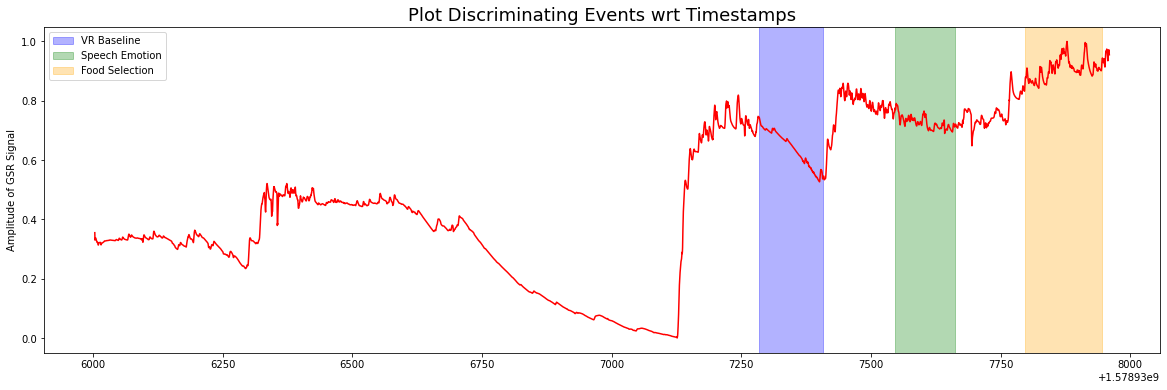

In [164]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(Downsampled_GSR['TimeStamp'],Downsampled_GSR['GSRC'],color='red')
ax.axvspan(VRBaseline_start, VRBaseline_end,label="VR Baseline",color="blue", alpha=0.3)
ax.axvspan(Speech_start, Speech_end,label="Speech Emotion",color="green", alpha=0.3)
ax.axvspan(Food_start, Food_end,label="Food Selection",color="orange", alpha=0.3)
ax.legend()
ax.set_ylabel('Amplitude of GSR Signal')
ax.set_title('Plot Discriminating Events wrt Timestamps', size=18)

In [165]:
GSR_Features = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/GSR_Processing/GSR_Features.csv')

In [166]:
GSR_Features.shape

(1462, 22)

In [167]:
GSR_Features = GSR_Features.rename(columns={"Unnamed: 0": "Index"})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



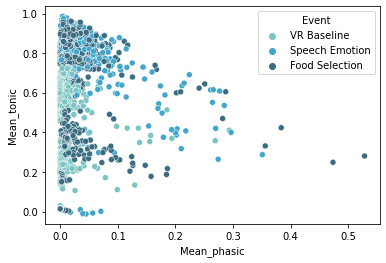

<Figure size 1440x720 with 0 Axes>

In [204]:
sns.scatterplot('Mean_phasic', 'Mean_tonic', data=GSR_Features, hue='Event',palette="GnBu_d")
plt.figure(figsize=(20,10))
plt.show()

In [170]:
HRV_Features = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/ECG_Processing/HRV_features_Label.csv') 

In [171]:
HRV_Features.shape

(723, 19)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



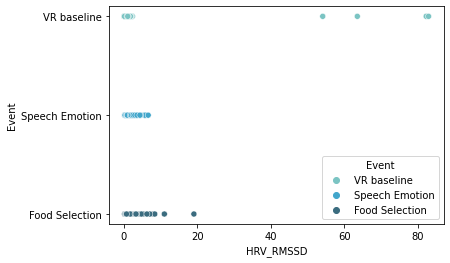

<Figure size 1440x720 with 0 Axes>

In [226]:
sns.scatterplot('HRV_RMSSD', 'Event', data=HRV_Features, hue='Event',palette="GnBu_d")
plt.figure(figsize=(20,10))
plt.show()

In [174]:
KFold_P_T = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/GSR_Processing/GSR_Predictions/Phasic&Tonic_predictions_K-FoldCV.csv')
KFold_P = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/GSR_Processing/GSR_Predictions/PhasicFeatures_predictions_K-FoldCV.csv')
KFold_T = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/GSR_Processing/GSR_Predictions/TonicFeatures_predictions_K-FoldCV.csv')
MeanLOGO_P_T = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/GSR_Processing/GSR_Predictions/Phasic&Tonic_predictions_MeanLOGO.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



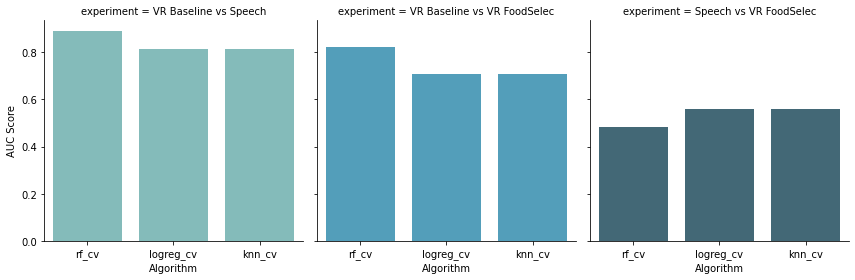

In [227]:
g = sns.FacetGrid(KFold_P_T, col="experiment", hue='experiment', height=4, aspect=1,palette="GnBu_d")
g.map(sns.barplot, 'Unnamed: 0', "auc_score_testing")
g.set_axis_labels("Algorithm", "AUC Score")

In [178]:
LOGO_P_T = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/GSR_Processing/GSR_Predictions/Phasic&Tonic_predictions_LOGO.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



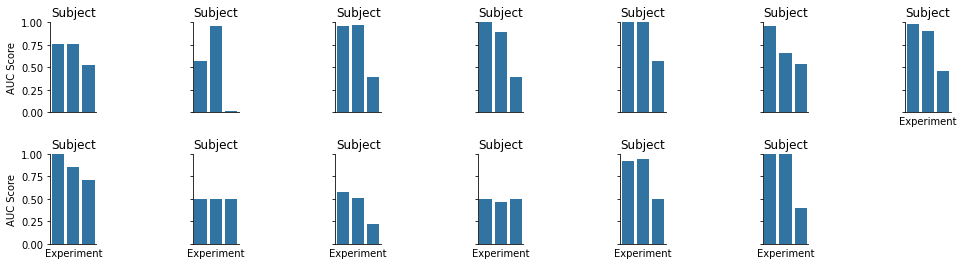

In [244]:
pal = dict(Lunch="seagreen", Dinner=".7")
g = sns.FacetGrid(LOGO_P_T, col="Unnamed: 0", col_wrap=7, height=2, ylim=(0, 1),palette=pal)
g.map(sns.barplot, "experiment", "auc_rf")
g.set_axis_labels("Experiment", "AUC Score")
g.set(xticks=[],yticks =[0,0.25,0.5,0.75,1],title='Subject')

In [253]:
HRV_K_Fold = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/ECG_Processing/ECG_Predictions/HRV_predictions_K-FoldCV.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



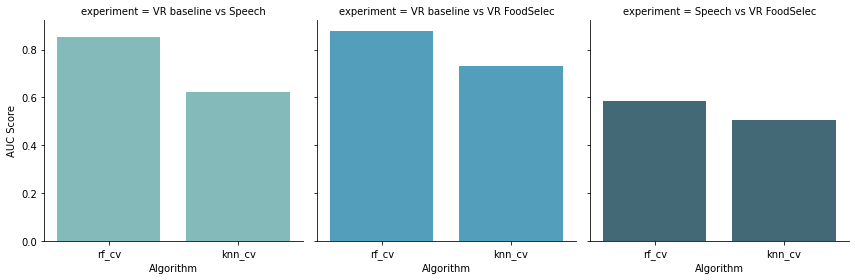

In [259]:
g = sns.FacetGrid(HRV_K_Fold, col="experiment", hue='experiment', height=4, aspect=1,palette="GnBu_d")
g.map(sns.barplot, 'Unnamed: 0', "auc_score_testing")
g.set_axis_labels("Algorithm", "AUC Score")

In [255]:
HRV_MeanLOGO = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/ECG_Processing/ECG_Predictions/HRV_predictions_MeanLOGO.csv')

In [257]:
HRV_SubjectLOGO = pd.read_csv('/content/gdrive/My Drive/Food_VR/Food_VR/ECG_Processing/ECG_Predictions/HRV_predictions_SubjectWise_LOGO.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



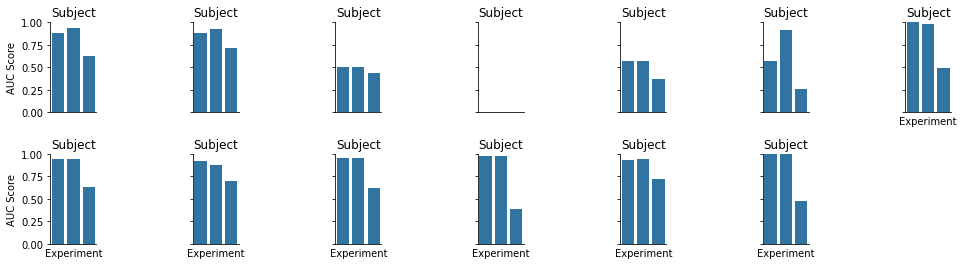

In [260]:
pal = dict(Lunch="seagreen", Dinner=".7")
g = sns.FacetGrid(HRV_SubjectLOGO, col="Unnamed: 0", col_wrap=7, height=2, ylim=(0, 1),palette=pal)
g.map(sns.barplot, "experiment", "auc_rf")
g.set_axis_labels("Experiment", "AUC Score")
g.set(xticks=[],yticks =[0,0.25,0.5,0.75,1],title='Subject')